In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn 
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import json
import os
import random
import io

In [2]:
X = []
all_events = []
masks = []


def get_signal(filename):
    with open(filename, 'r') as f:
        return json.load(f)[0]


def get_events(filename):
    with open(filename, 'rb') as f:
        events = json.load(f)
    events = list(filter(lambda x: x["type"] == 1, events))
    events = list(filter(lambda x: x["data"]["type"] >= 5, events))
    return events


directory = 'W:/mask/'
for filename in sorted(os.listdir(directory)):
    path = directory + "/" + filename
    if "signal" in filename:
        X.append(get_signal(path))
        if filename == "17470_signal.json":
            X[-1] = X[-1][:17001523]
    if "events" in filename:
        all_events.append(get_events(path))
        
for signal, events in zip(X, all_events):
    mask = np.zeros(len(signal), dtype=np.int8)
    for event in events:
        m = event["data"]
        mask[m["begin"]:m["end"]] = m["type"] - 4
    masks.append(mask)

    
X = np.array(X)
masks = np.array(masks)

In [3]:
sample_rate = 500

In [4]:
# Вспомогательные функции, превращающие маску в сегментацию

v_to_del = {1:'noise', 2:'artefacts'}

def remove_small(signal):
    max_dist = 12
    last_zero = 0
    for i in range(len(signal)):
        if signal[i] == 0:
            if i - last_zero < max_dist:
                signal[last_zero:i] = 0
            last_zero = i

def merge_small(signal):
    max_dist = 100
    lasts = np.full(signal.max() + 1, -(max_dist+1))
    for i in range(len(signal)):
        m = signal[i]
        if i - lasts[m] < max_dist and m > 0:
            signal[lasts[m]:i] = m
        lasts[m] = i

def mask_to_delineation(mask):
    merge_small(mask)
    remove_small(mask)
    delineation = {'noise':[], 'artefacts':[]}
    i = 0
    mask_length = len(mask)
    while i < mask_length:
        v = mask[i]
        if v > 0:
            delineation[v_to_del[v]].append([i, 0])
            while i < mask_length and mask[i] == v:
                delineation[v_to_del[v]][-1][1] = i
                i += 1
            t = delineation[v_to_del[v]][-1]
        i += 1
    return delineation

In [5]:
wave_type_to_color = {
    "artefacts": "yellow",
    "noise": "red"
}

def plot_signal_with_mask(signal, mask):
    plt.figure(figsize=(18, 5))
    plt.title("Сигнал с маской")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда (мВ)")
    x_axis_values = np.linspace(0, len(signal) / sample_rate, len(signal))
    plt.plot(x_axis_values, signal, linewidth=2, color="black")
    
    delineation = mask_to_delineation(mask)
    for wave_type in ["noise", "artefacts"]:
        color = wave_type_to_color[wave_type]
        for begin, end in delineation[wave_type]:
            begin /= sample_rate
            end /= sample_rate
            plt.axvspan(begin, end, facecolor=color, alpha=0.5)

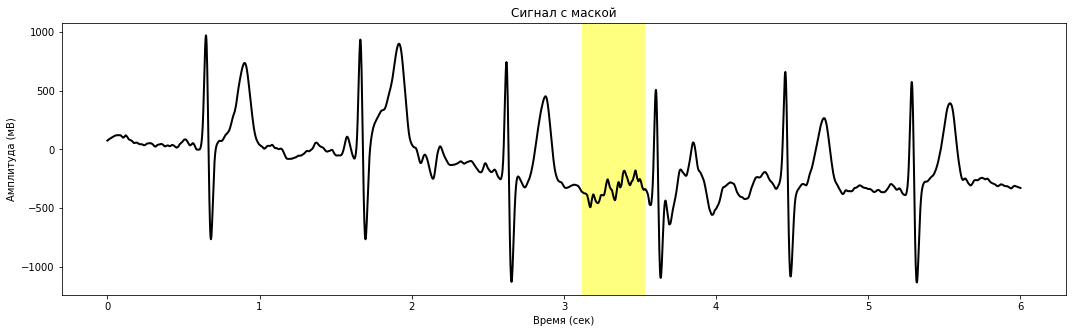

In [6]:
plot_signal_with_mask(X[4][284000:287000], masks[4][284000:287000])

In [7]:
import torch.nn.functional as F

weights = torch.Tensor([1., 5., 5.])


def get_loss_with_confusion(model, X_batch, y_batch, w):
    logits = model(X_batch)
    logits = logits[:, :, 2000:-2000]
    y_batch = y_batch[:, 2000:-2000]
    w = w[:, 2000:-2000]
    loss = (w * F.cross_entropy(logits, y_batch, weight=weights)).mean()
    
    y_batch = y_batch.data.numpy().reshape(-1)
    logits = logits.data.numpy()
    y_pred = np.argmax(logits, axis=1).reshape(-1)
    return loss, confusion_matrix(y_batch, y_pred, labels=(0, 1, 2))
    

def get_loss(model, X_batch, y_batch, w):
    logits = model(X_batch)
    logits = logits[:, :, 2000:-2000]
    y_batch = y_batch[:, 2000:-2000]
    w = w[:, 2000:-2000]
    return (w * F.cross_entropy(logits, y_batch, weight=weights)).mean()

In [8]:
class UNetConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetConv, self).__init__()
        self._model = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=9, padding=4),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=9, padding=4),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, X):
        return self._model(X)
    
    
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDown, self).__init__()
        self._model = nn.Sequential(
            nn.MaxPool1d(3),
            UNetConv(in_channels, out_channels)
        )
    
    def forward(self, X):
        return self._model(X)
    

class UNetUp(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels):
        super(UNetUp, self).__init__()
        self._up = nn.ConvTranspose1d(in_channels, in_channels, kernel_size=9, stride=3, padding=3)
        self._model = UNetConv(in_channels + in_channels_skip, out_channels)
    
    def forward(self, X_skip, X):
        X = self._up(X)  
        diff = X_skip.size()[2] - X.size()[2]
        X = F.pad(X, (diff // 2, diff - diff // 2))  
        return self._model(torch.cat([X_skip, X], dim=1))

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        n = 4
        self._input = UNetConv(in_channels, n)
        self._down1 = UNetDown(n, 2*n)
        self._down2 = UNetDown(2*n, 4*n)
        self._down3 = UNetDown(4*n, 8*n)
        self._down4 = UNetDown(8*n, 16*n)
        self._up1 = UNetUp(16*n, 8*n, 8*n)
        self._up2 = UNetUp(8*n, 4*n, 4*n)
        self._up3 = UNetUp(4*n, 2*n, 2*n)
        self._up4 = UNetUp(2*n, n, n)
        self._output = nn.Conv1d(n, num_classes, kernel_size=1)
        
    def forward(self, X):
        x1 = self._input(X)
        x2 = self._down1(x1)
        x3 = self._down2(x2)
        x4 = self._down3(x3)
        x = self._down4(x4)
        x = self._up1(x4, x)
        x = self._up2(x3, x)
        x = self._up3(x2, x)
        x = self._up4(x1, x)
        return self._output(x)

In [10]:
model = UNet(1, 3)

In [11]:
model.load_state_dict(torch.load("unet"))
model.eval()

UNet(
  (_input): UNetConv(
    (_model): Sequential(
      (0): Conv1d(1, 4, kernel_size=(9,), stride=(1,), padding=(4,))
      (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(4, 4, kernel_size=(9,), stride=(1,), padding=(4,))
      (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (_down1): UNetDown(
    (_model): Sequential(
      (0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (1): UNetConv(
        (_model): Sequential(
          (0): Conv1d(4, 8, kernel_size=(9,), stride=(1,), padding=(4,))
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(8, 8, kernel_size=(9,), stride=(1,), padding=(4,))
          (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
 

In [123]:
# получение маски по сигналу
def get_mask(signal):
    signal = np.expand_dims(signal, axis=(0, 1))
    signal = torch.FloatTensor(signal)
    mask = model(signal)[0]
    mask = mask.argmax(axis=0)
    return mask.data.numpy().astype(np.int32)

In [13]:
# confusion matrix на исходных полноценных ЭКГ
def conf_matrix_10_minutes(signal, true_mask):
    signal = np.array(signal) / 1000
    conf_matrix = np.zeros((3,3), dtype=np.int64)
    index = 0
    while len(signal) - index >= 300000:
        mask = get_mask(signal[index:index+300000])
        conf_matrix += confusion_matrix(true_mask[index+2500:index+300000-2500], mask[2500:-2500], labels=[0,1,2])
        index += 295000
    mask = get_mask(signal[index:])
    conf_matrix += confusion_matrix(true_mask[index:][2500:-2500], mask[2500:-2500], labels=[0,1,2])
    return conf_matrix

In [14]:
conf_matrix_10_minutes(X[0], masks[0])

array([[295729,      0,  10241],
       [     0,   4301,      0],
       [  1353,     27,  13349]], dtype=int64)

In [15]:
confusion_matrix(masks[0][2500:-2500], get_mask(np.array(X[0]) / 1000)[2500:-2500], labels=[0,1,2])

array([[296275,      0,   9695],
       [     0,   4301,      0],
       [  1360,     22,  13347]], dtype=int64)

In [131]:
def get_full_mask_ecg(signal):
    signal = np.array(signal) / 1000
    mask_full = np.array([], dtype = np.int32)
    index = 0
    begin = 0
    while len(signal) - index >= 400000:
        if index > 0:
            begin = 2500
        mask_full = np.hstack([mask_full, get_mask(signal[index:index+300000])[begin:-2500]])
        index += 295000
    mask_full = np.hstack([mask_full, get_mask(signal[index:])[begin:]])
    return mask_full

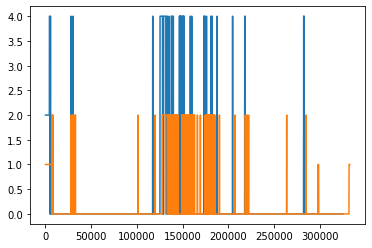

In [92]:
plt.plot(masks[0][2500:-2500] * 2)
plt.plot(get_full_mask_ecg(X[0]))

In [263]:
#посчитаем accuracy в окрестности 1 секунда слева, 1 секунд
def accuracy_in_vicinity(true_mask, unet_mask):
    r = np.zeros(1001)
    r[:500] = np.linspace(0, 1, 500)
    r[500] = 1
    r[501:] = np.linspace(0, 1, 500)[::-1]
    
    accuracy = []
    index = 0
    #m = (true_mask==unet_mask)
    m = np.full(len(true_mask), 1)
    m[(true_mask == 2) & (unet_mask == 0)] = 0
    
    current_accuracy = (m[:1001] * r).sum()
    accuracy.append(current_accuracy)
    while 1001 + index < len(true_mask):
        index += 1
        accuracy.append((m[index:1001+index] * r).sum())
    return accuracy

In [416]:
result = accuracy_in_vicinity(masks[0], get_full_mask_ecg(X[0]))

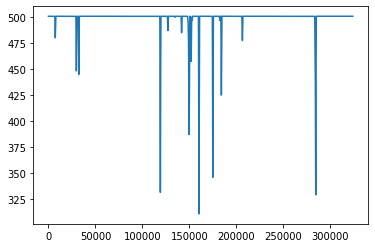

In [417]:
plt.plot(result[:-5000])

In [418]:
a = np.argsort(result[:-5000]) + 500

In [419]:
a[600:700]

array([160614, 284958, 119583, 119741, 285140, 284957, 160613, 160877,
       119582, 119742, 285141, 284956, 119743, 119581, 160878, 160612,
       285142, 284955, 119744, 119580, 285143, 160879, 160611, 284954,
       119579, 119745, 284953, 285144, 160610, 160880, 119578, 119746,
       284952, 285145, 160881, 160609, 119747, 119577, 175511, 175512,
       175513, 175510, 175514, 175509, 175508, 175515, 175516, 175507,
       284951, 175517, 175506, 175518, 175505, 175504, 175519, 175503,
       175520, 175502, 175521, 285146, 175522, 175501, 175523, 175500,
       175524, 175499, 119748, 119576, 284950, 175498, 175525, 160882,
       160608, 175526, 175497, 175496, 175527, 175495, 175528, 285147,
       175494, 175529, 284949, 119575, 119749, 175530, 175493, 175531,
       175492, 160883, 160607, 175532, 175491, 175490, 175533, 284948,
       285148, 175534, 175489, 119574], dtype=int64)

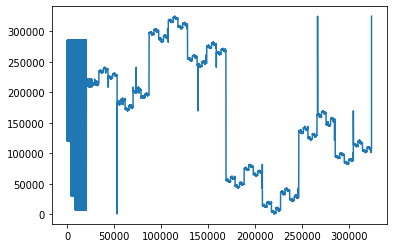

In [420]:
plt.plot(a)

In [412]:
#b = np.argsort(result[:-5000]) + 500
#plt.plot(b[400:])

In [421]:
a[:100]

array([160745, 160746, 160744, 160747, 160743, 160748, 160742, 160741,
       160749, 160740, 160750, 160739, 160751, 160738, 160752, 160737,
       160753, 160754, 160736, 160735, 160755, 160734, 160756, 160757,
       160733, 160758, 160732, 160731, 160759, 160730, 160760, 160761,
       160729, 160762, 160728, 160727, 160763, 160726, 160764, 160765,
       160725, 160724, 160766, 160767, 160723, 160768, 160722, 160721,
       160769, 160720, 160770, 160719, 160771, 160772, 160718, 160773,
       160717, 160716, 160774, 160775, 160715, 160714, 160776, 160777,
       160713, 160712, 160778, 160779, 160711, 160780, 160710, 160709,
       160781, 160782, 160708, 160783, 160707, 160706, 160784, 160785,
       160705, 160786, 160704, 160703, 160787, 160702, 160788, 160701,
       160789, 160700, 160790, 160791, 160699, 160698, 160792, 160697,
       160793, 160794, 160696, 160695], dtype=int64)

In [422]:
def unique_index(mass, offset):
    unique = np.array([mass[0]])
    left = np.array([mass[0] - offset])
    right = np.array([mass[0] + offset])
    for i in range(len(mass)):
        count = 0
        for j in range(len(left)):
            if left[j] >= mass[i] or mass[i] >= right[j]:
                count += 1
        if(count == len(left)):
            left = np.append(left, mass[i] - offset)
            right = np.append(right, mass[i] + offset)
            unique = np.append(unique, mass[i])
    return unique

In [423]:
aa = unique_index(a,1500) 

In [424]:
aa

array([160745, 285054, 119662, 175511, 150198, 184615,  32843,  30251,
       152463, 207011,   7828, 142253, 127681, 183007, 135372, 148698,
       218371, 210161, 221485, 208661, 219905, 212894, 215232, 216851,
       225058, 234492, 236011, 232061, 239353, 240873, 237530, 223554,
       229630, 227199,    500, 180099, 188550, 186426, 172311, 170187,
       177975, 173903, 201292, 199169, 205506, 203415, 192798, 190674,
       197045, 194921, 243604, 297217, 298816, 294659, 302333, 303932,
       300415, 286984, 288583, 282758, 292101, 290182, 317682, 319281,
       315124, 322798, 324397, 320880, 307449, 309048, 305531, 312566,
       310647, 254618, 256217, 252060, 259734, 261333, 257816, 245664,
       249502, 247263, 275083, 276682, 272525, 280200, 278281, 264850,
       266449, 262932, 269967, 268048, 162499,  55771,  57285,  53349,
        60615,  62129,  58799,  46083,  47597,  43661,  50927,  49111,
        75148,  76662,  72726,  79992,  81506,  78176,  65459,  66973,
      

In [425]:
offset = 1000

In [426]:
def draw_ecg(aa, index, offset):
    plot_signal_with_mask(X[0][aa[index] - offset: aa[index] + offset], masks[0][aa[index] - offset: aa[index] + offset])
    plot_signal_with_mask(X[0][aa[index] - offset: aa[index] + offset], get_full_mask_ecg(X[0])[aa[index] - offset: aa[index] + offset])

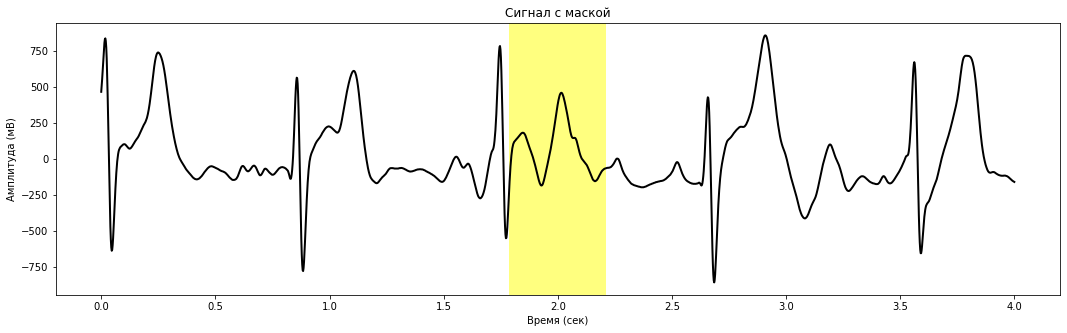

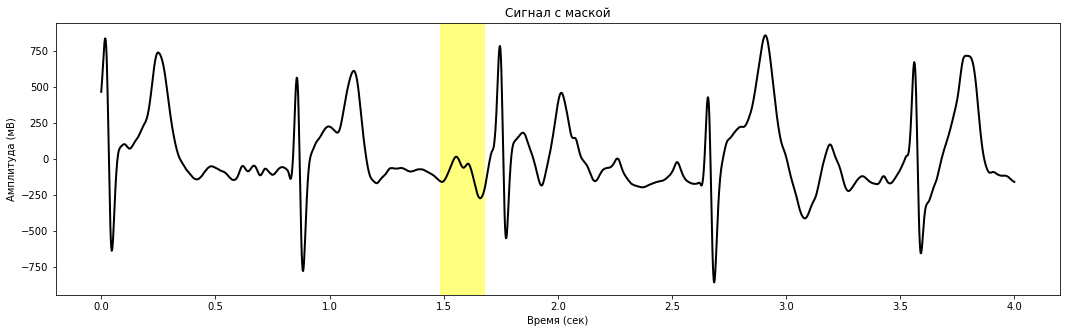

In [389]:
draw_ecg(aa,0,offset)

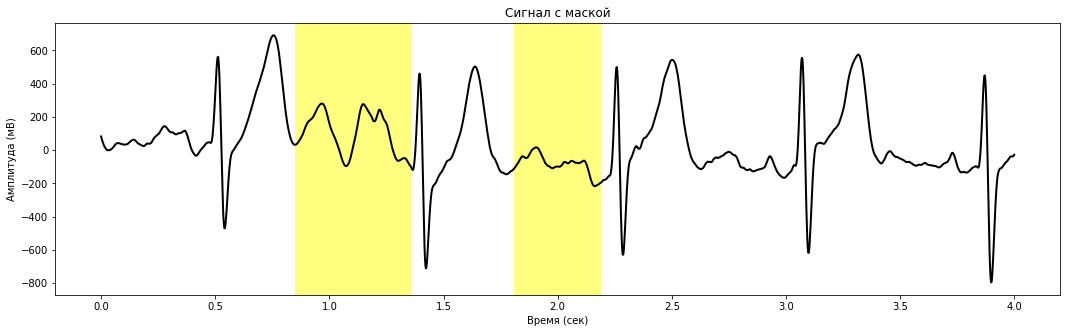

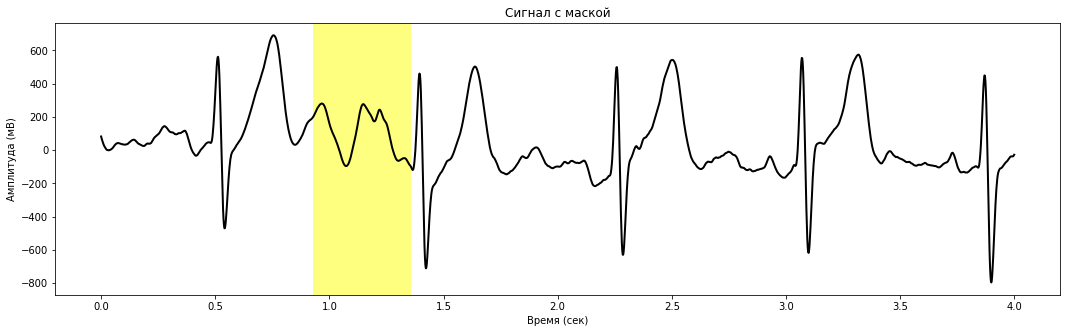

In [390]:
draw_ecg(aa,1,offset)

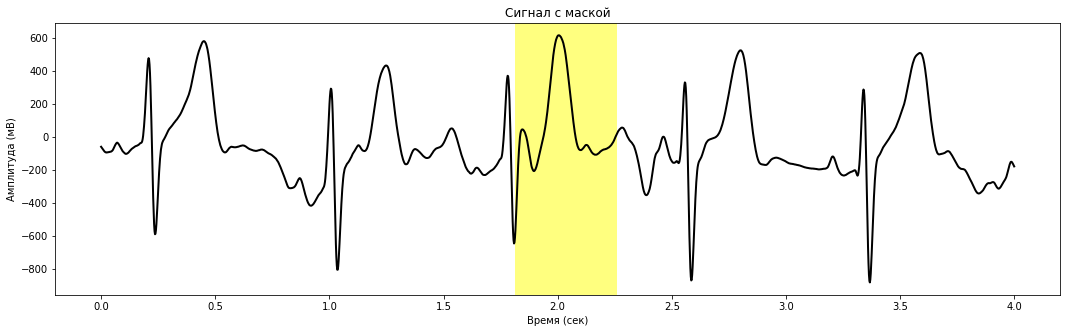

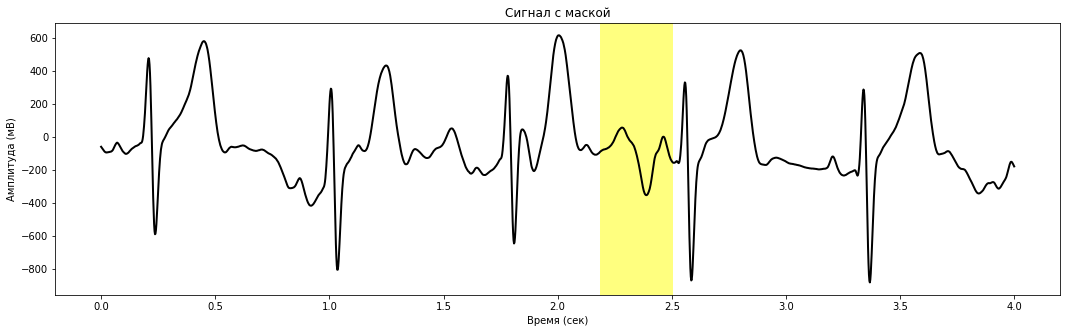

In [391]:
draw_ecg(aa,2,offset)

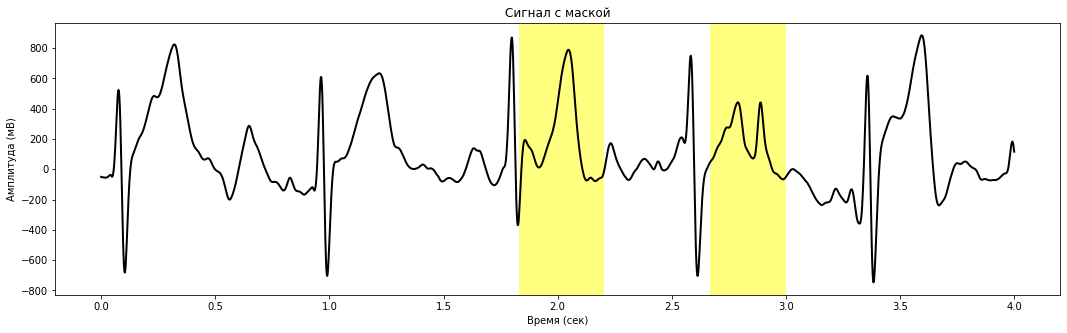

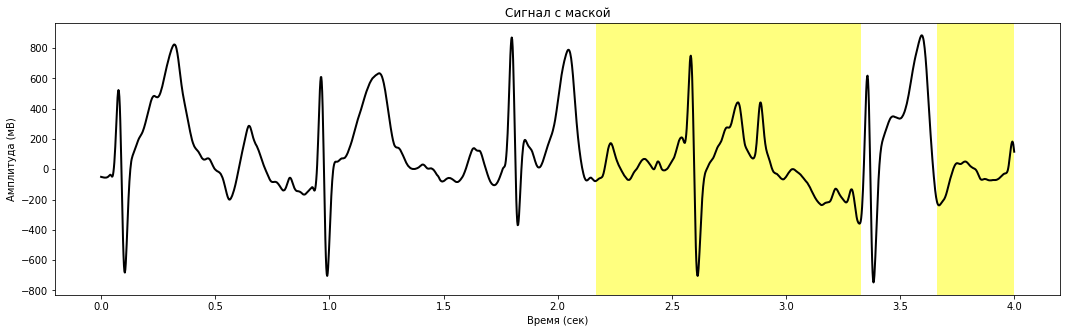

In [392]:
draw_ecg(aa,3,offset)

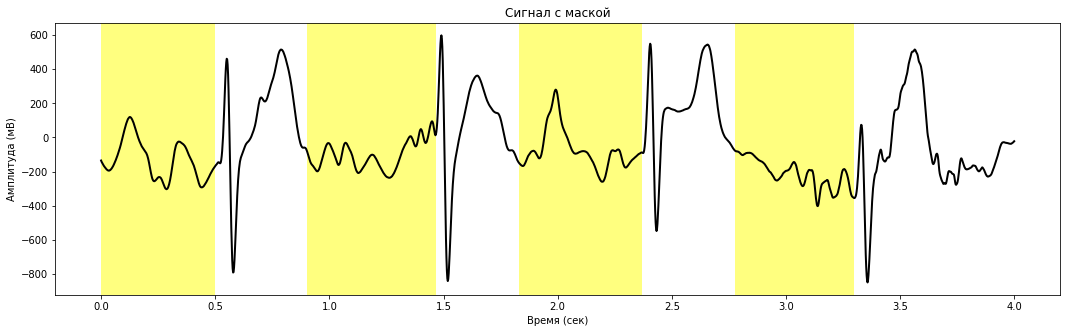

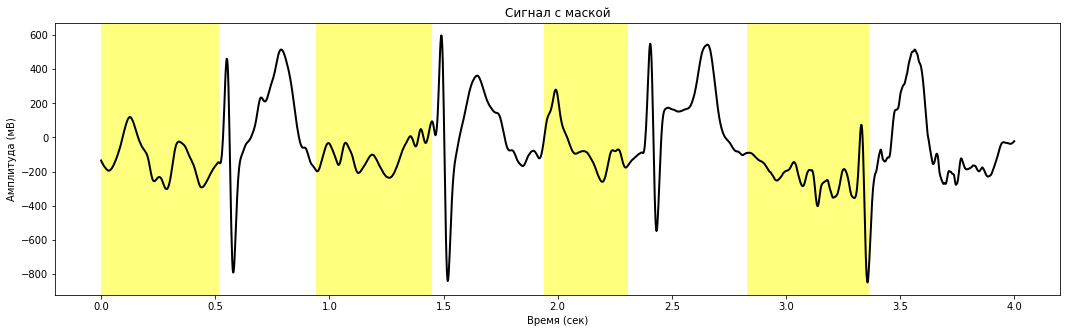

In [393]:
draw_ecg(aa,4,offset)

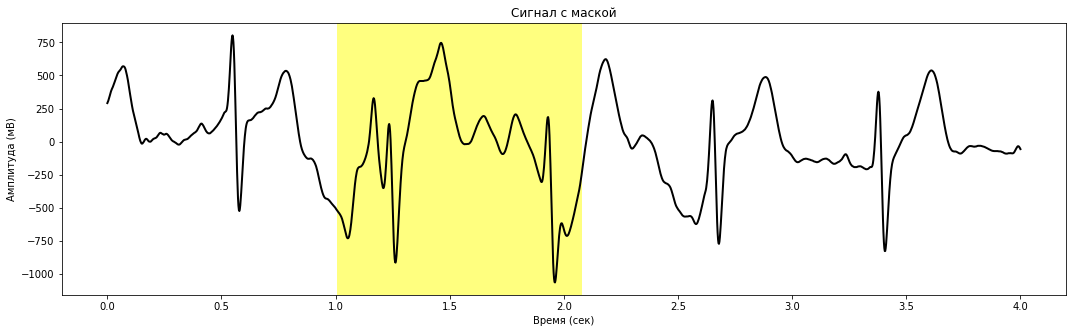

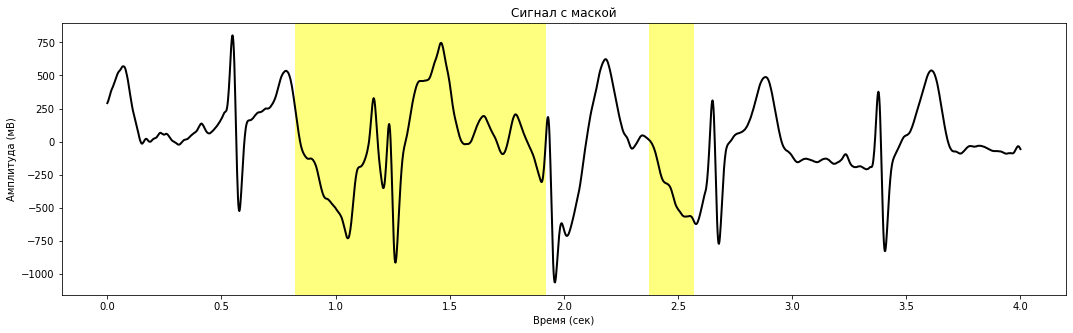

In [394]:
draw_ecg(aa,5,offset)

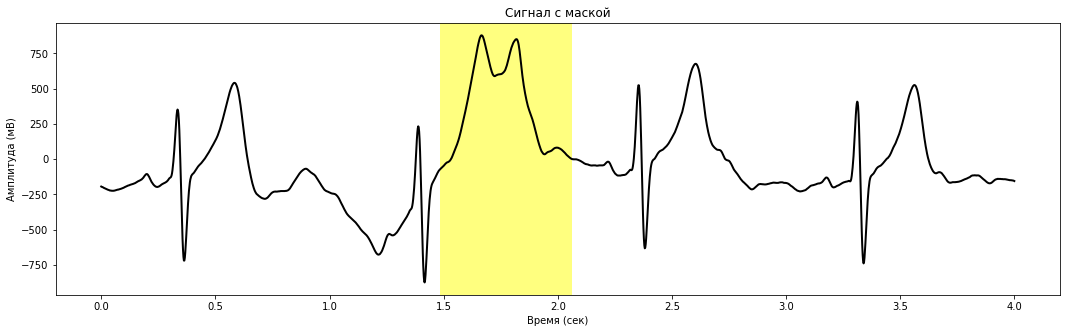

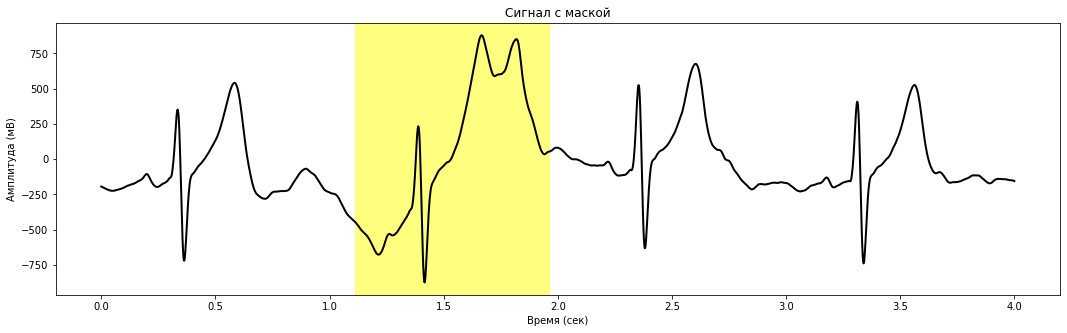

In [395]:
draw_ecg(aa,6,offset)

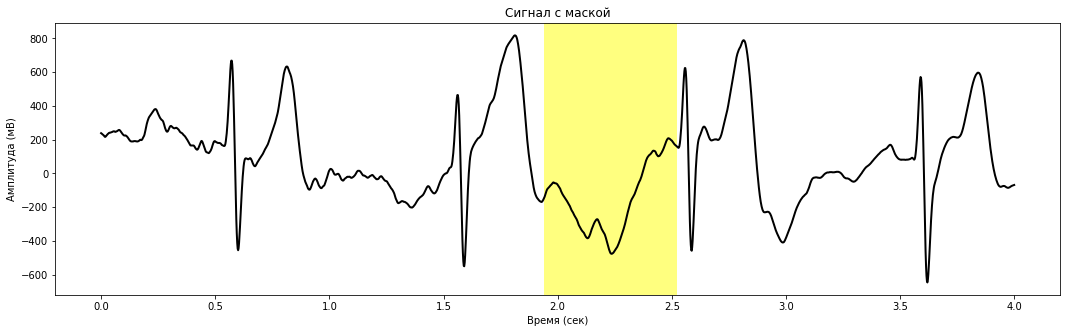

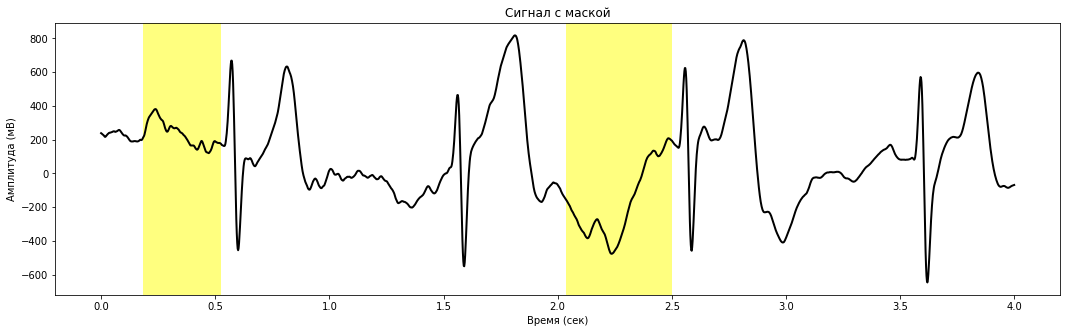

In [396]:
draw_ecg(aa,7,offset)

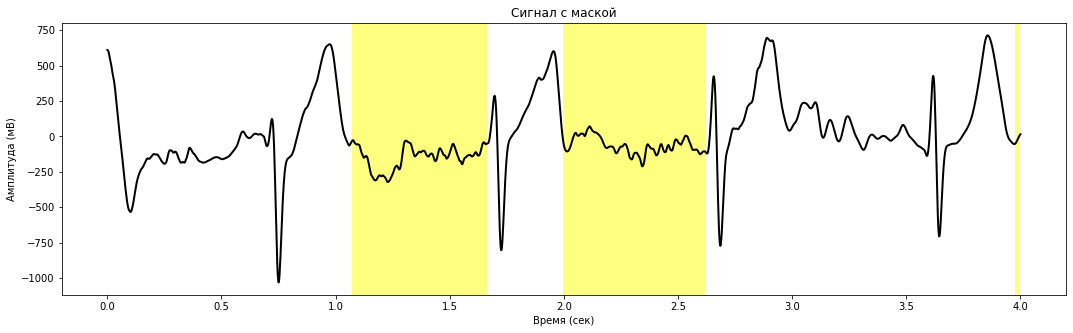

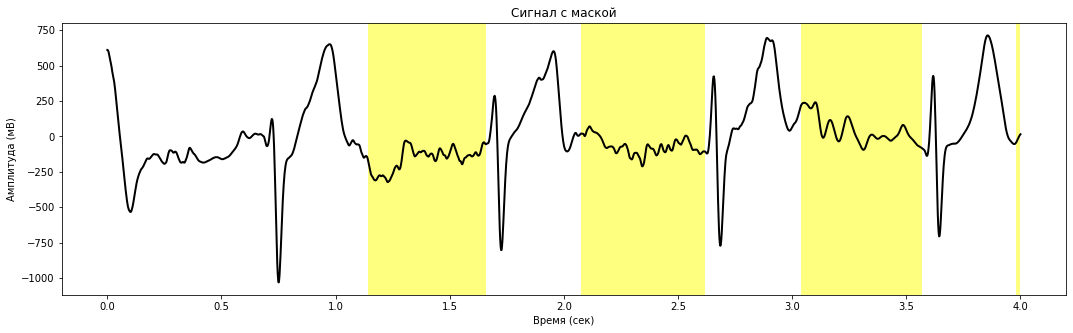

In [397]:
draw_ecg(aa,8,offset)

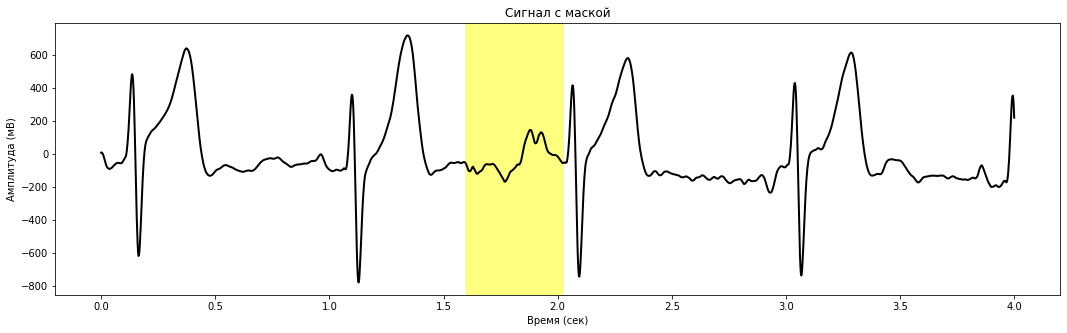

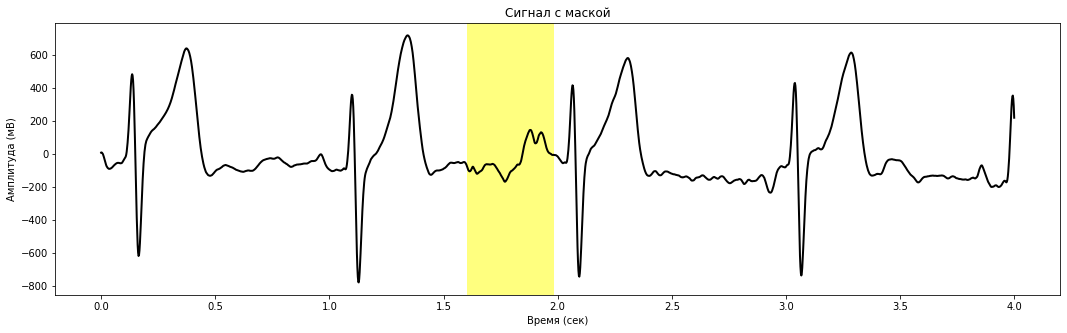

In [398]:
draw_ecg(aa,9,offset)

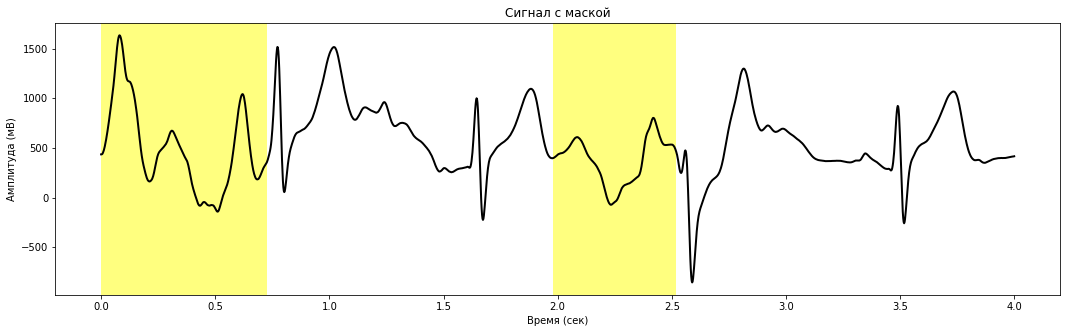

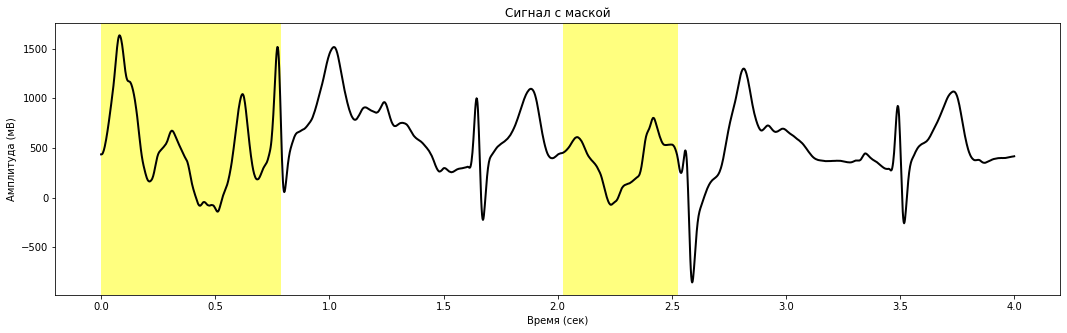

In [399]:
draw_ecg(aa,10,offset)

In [400]:
result = accuracy_in_vicinity(masks[1], get_full_mask_ecg(X[1]))

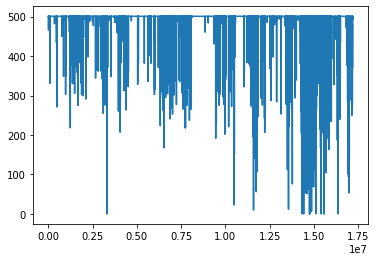

In [402]:
plt.plot(result[:-5000])

In [403]:
a = np.argsort(result[:-5000]) + 500

In [404]:
aa = unique_index(a,1500) 

KeyboardInterrupt: 

In [405]:
aa

array([160745, 285054, 119662, 175511, 150198, 184615,  32843,  30251,
       152463, 207011,   7828, 142253, 127681, 183007, 135372, 148698,
       218371, 210161, 221485, 208661, 219905, 212894, 215232, 216851,
       225058, 234492, 236011, 232061, 239353, 240873, 237530, 223554,
       229630, 227199,    500, 180099, 188550, 186426, 172311, 170187,
       177975, 173903, 201292, 199169, 205506, 203415, 192798, 190674,
       197045, 194921, 243604, 297217, 298816, 294659, 302333, 303932,
       300415, 286984, 288583, 282758, 292101, 290182, 317682, 319281,
       315124, 322798, 324397, 320880, 307449, 309048, 305531, 312566,
       310647, 254618, 256217, 252060, 259734, 261333, 257816, 245664,
       249502, 247263, 275083, 276682, 272525, 280200, 278281, 264850,
       266449, 262932, 269967, 268048, 162499,  55771,  57285,  53349,
        60615,  62129,  58799,  46083,  47597,  43661,  50927,  49111,
        75148,  76662,  72726,  79992,  81506,  78176,  65459,  66973,
      